In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(8,6)})

# Read and heal data

We read the data from https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data because the dataset is larger than the one from kaggle.
We then remove NaN values and a specific edge case about beeing member of the EU from a japanese flight.

In [29]:
all_countries = pd.read_excel("./COVID-19-geographic-disbtribution-worldwide-2020-03-13.xls")

In [30]:
all_countries.isna().sum()

DateRep            0
CountryExp         0
NewConfCases       0
NewDeaths          0
GeoId              0
Gaul1Nuts1      4420
EU                 0
dtype: int64

In [31]:
all_countries = all_countries.drop(columns=['Gaul1Nuts1'])
all_countries = all_countries[all_countries['EU'] != 0]

# Data Exploration

In [35]:
all_countries.head()

,DateRep,CountryExp,NewConfCases,NewDeaths,GeoId,EU
0,2020-03-11,Afghanistan,3,0,AF,Non-EU/EEA
1,2020-03-08,Afghanistan,3,0,AF,Non-EU/EEA
2,2020-03-02,Afghanistan,0,0,AF,Non-EU/EEA
3,2020-03-01,Afghanistan,0,0,AF,Non-EU/EEA
4,2020-02-29,Afghanistan,0,0,AF,Non-EU/EEA


In [8]:
all_countries['CountryExp'].unique().shape[0]

119

### Search for outliers in the number of confirmed cases first

In [12]:
summed = all_countries.groupby(['CountryExp']).sum()
summed[summed['NewConfCases'] > 10000]

,NewConfCases,NewDeaths
CountryExp,,
China,80954,3179
Iran,10075,429
Italy,15113,1016


### Split the set for Vizualization in one containing china and one without it, because china is a massive outlier.

In [34]:
without_china = all_countries[all_countries['CountryExp'] != 'China']
without_china['NewConfCases'].mean(), all_countries['NewConfCases'].mean()

(10.952380952380953, 27.507539764511463)

## Plot new infections over time

In [44]:
new_cases = all_countries.groupby(['DateRep']).sum()

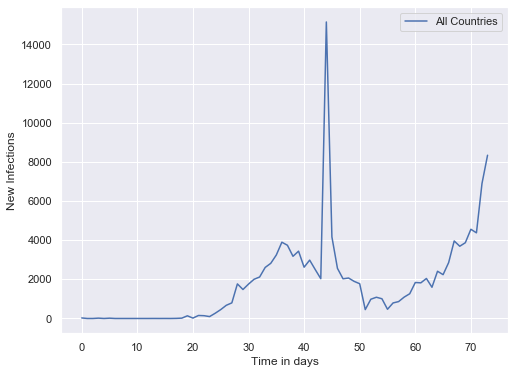

In [45]:
plt.plot(range(74), new_cases['NewConfCases'].values);
plt.legend(['All Countries'])
plt.xlabel('Time in days')
plt.ylabel('New Infections');

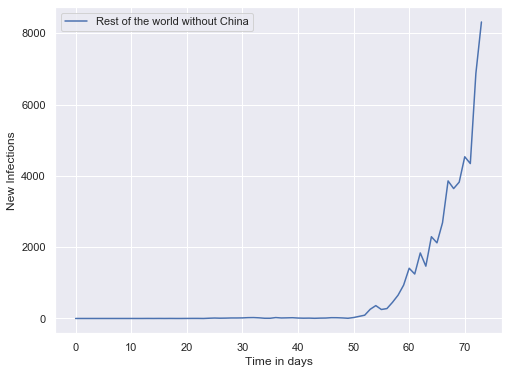

In [47]:
plt.plot(range(74), without_china.groupby(['DateRep']).sum()['NewConfCases'].values);
plt.legend(['Rest of the world without China'])
plt.xlabel('Time in days')
plt.ylabel('New Infections');

### Distribution of the new confirmed cases

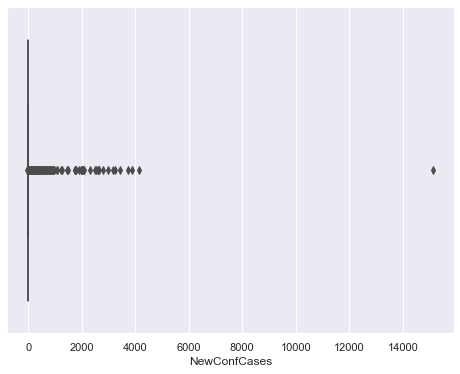

In [50]:
sns.boxplot(x="NewConfCases", data=all_countries);

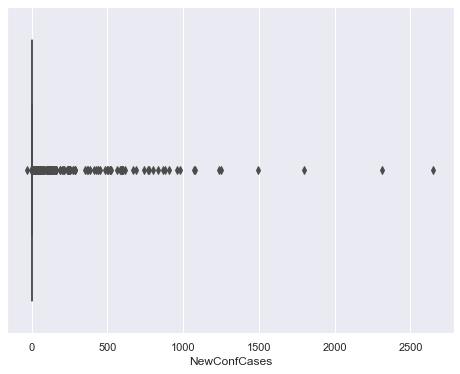

In [48]:
sns.boxplot(x="NewConfCases", data=without_china);

### New cases andnew  deaths correlation

We can potentialy find strong correlation between new confirmed cases and new deaths.
We plot the obvious linear relationship and add a 95% confidence intervall for our function.

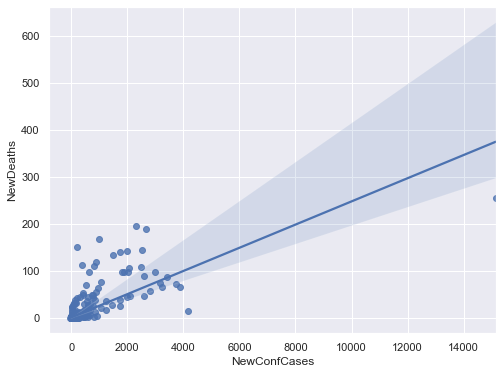

In [13]:
sns.regplot(x="NewConfCases", y="NewDeaths", data=all_countries);

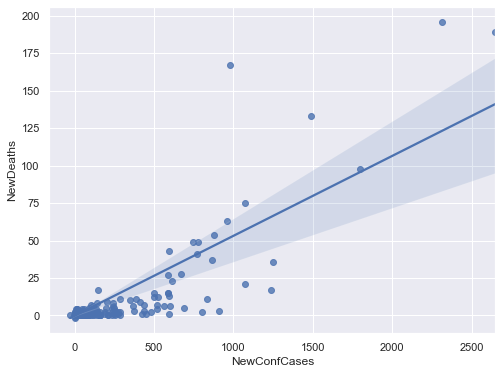

In [15]:
sns.regplot(x="NewConfCases", y="NewDeaths", data=without_china);

When the number of new infections is low, so is death ratio. At around 1500 new daily infection we see the death ratio rising above our linear relationship. 

Maybe we can explain this correlation with a causal relationship like the overload of hospitals. It's not unlikely either that the death ratio is low at the beginning because people just started to get infected and aren't at the critial point of Covid19 yet.

In [60]:
sns.set(rc={'figure.figsize':(12,10)})

### Group by EU membership

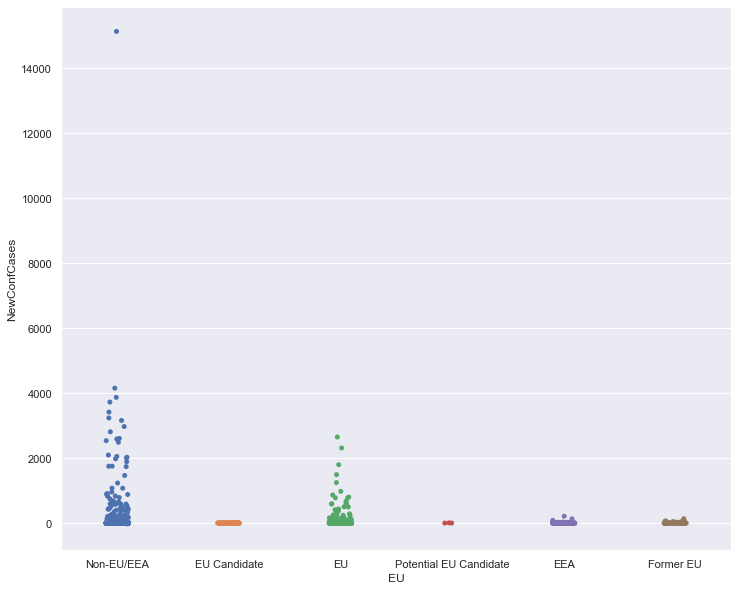

In [17]:
sns.stripplot(x="EU", y="NewConfCases", data=all_countries);

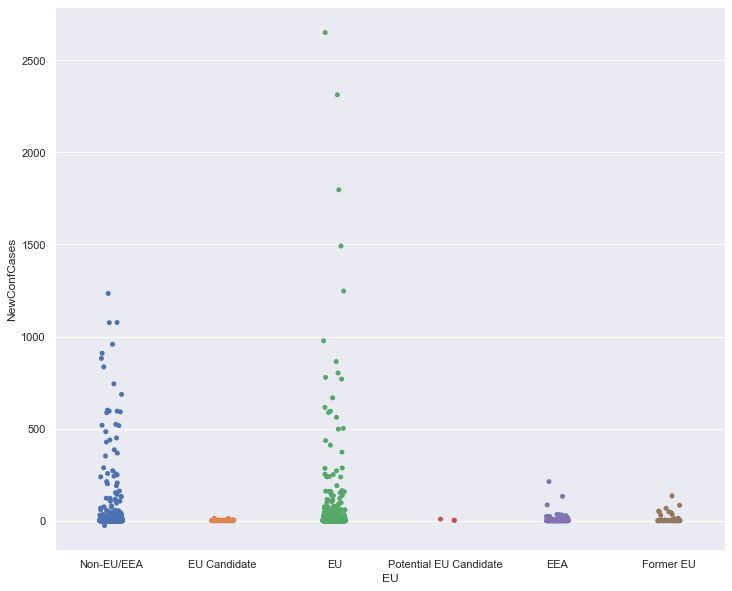

In [18]:
sns.stripplot(x="EU", y="NewConfCases", data=without_china);

In [19]:
sns.set(rc={'figure.figsize':(8,6)})